# Task 2 – Advanced Data Science Techniques / MS Azure Machine Learning Studio

## 1. Preliminary Steps

In [1]:
## Imports
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split



### Imports for modeling 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the dataset
loans = pd.read_csv('LoanStats.csv')

In [3]:
len(loans)

39786

## 2. Data Understanding

In [4]:
loans.sort_values(by='annual_inc', ascending=False)

int_rate  loan_amnt  term grade home_ownership  annual_inc  \
30176     12.73       5000    36     C       MORTGAGE   6000000.0   
29708     10.62      25000    60     B       MORTGAGE   3900000.0   
39158     12.29       8450    36     C           RENT   2039784.0   
23618      6.17       1500    36     A       MORTGAGE   1900000.0   
7268      14.27      12025    36     C           RENT   1782000.0   
...         ...        ...   ...   ...            ...         ...   
29636     10.62       2000    60     B            OWN      4800.0   
30795     12.73       1200    36     C           RENT      4200.0   
37778     16.95       2750    36     E           RENT      4200.0   
29352     11.86       1400    36     B           RENT      4080.0   
35570     13.22       2000    36     C           RENT      4000.0   

                  purpose  
30176    home_improvement  
29708    home_improvement  
39158  debt_consolidation  
23618         credit_card  
7268   debt_consolidation  
...                   ...  
29636                 car  
30795         educational  
37778         educational  
29352  debt_consolidation  
35570         educational  

[39786 rows x 7 columns]

In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39786 entries, 0 to 39785
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   int_rate        39786 non-null  float64
 1   loan_amnt       39786 non-null  int64  
 2   term            39786 non-null  int64  
 3   grade           39786 non-null  object 
 4   home_ownership  39786 non-null  object 
 5   annual_inc      39786 non-null  float64
 6   purpose         39786 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 2.1+ MB


In [6]:
loans['term'] = loans['term'].astype('string')
loans['home_ownership'] = loans['home_ownership'].astype('string')
loans['purpose'] = loans['purpose'].astype('string')

In [7]:
loans.home_ownership.value_counts()

RENT        18918
MORTGAGE    17703
OWN          3064
OTHER          98
NONE            3
Name: home_ownership, dtype: Int64

### count of loans requested differentiated by home_ownership

In [8]:

fig = px.histogram(loans, x="home_ownership")
fig.show()

### count of loans requested differentiated by purpose

In [9]:
fig = px.histogram(loans, x="purpose")
fig.show()

### Cumulative of loans differentiated by purpose

In [10]:
fig = px.histogram(loans, x="purpose", y="loan_amnt")
fig.show()

In [11]:
loans.grade.value_counts()

B    12035
A    10085
C     8111
D     5325
E     2858
F     1054
G      318
Name: grade, dtype: int64

### Understanding the amount of loans granted based on the grade and the purpose

After getting the bar chart not surprisingly and according to the [lending club web page](https://www.lendingclub.com/foliofn/rateDetail.action) Grades such A, B and C are the most granted since they involve lower risks 

In [12]:
purpose_grade = loans[['purpose' , 'grade']].groupby(by=['purpose', 'grade']).size()
purpose_grade = purpose_grade.to_frame(name = 'size').reset_index()
purpose_count = purpose_grade.groupby(by='purpose')['size'].sum().reset_index()
result = pd.merge(purpose_grade,
                 purpose_count,
                 on='purpose',
                 how='inner')
result = result.rename(columns={"size_x": "count", "size_y": "count_by_grade"})

# get the percentage of the grade per purpose type
result['percentage'] = result['count'] / result['count_by_grade']

fig = px.bar(result, x="purpose", y="percentage", color="grade", title="Long-Form Input")
fig.show()

### Identifying correlations among variables

The heatmap clearly shows a high correlation between the following features:

- term and loan_amnt
- int_rate and term

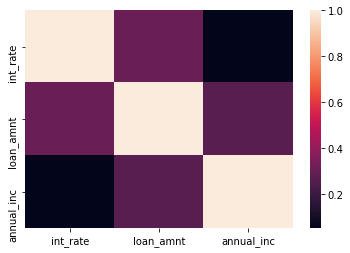

In [13]:
num_features = loans[['int_rate', 'loan_amnt', 'term', 'annual_inc']]


sns.heatmap(num_features.corr());

### Potential outliers in annual_inc

In [14]:
fig = px.histogram(loans, x="annual_inc", histnorm='percent')
fig.show()

In [15]:
fig = px.histogram(loans, x="int_rate", histnorm='percent')
fig.show()

# Scatterplot to find the correlation between interest rate and annual income, also classified by grade

Not surprisingly the higher the rate the grade gets systematically increased alphabetically, which means there is a direct correlation

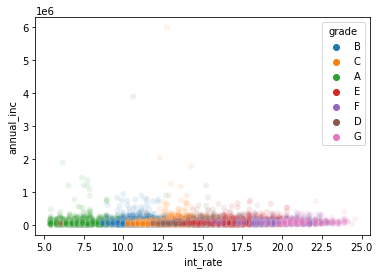

In [16]:

result = sns.scatterplot(data=loans, x='int_rate', y='annual_inc', hue='grade',alpha=.1)


In [93]:
fig = px.scatter(loans, x='term', y='int_rate', color='grade')
fig.show()

## 3. Data Preparation

According to Leading club base loan terms should be either 30 or 60, so I am checking it

In [17]:
loans.term.value_counts()

36    29096
60    10690
Name: term, dtype: Int64

According to Leading club loans should be up to $40000 USD, so I am checking it in the dataframe

In [18]:
loans[loans.loan_amnt > 40000]

Empty DataFrame
Columns: [int_rate, loan_amnt, term, grade, home_ownership, annual_inc, purpose]
Index: []

According to Leading club loans page `Loan amounts range from $1,000 to $40,000 and loan term lengths are 36 months or 60 months. Some amounts and term lengths may be unavailable in certain states.` Therefore I am deleting amounts lower than 1000 USD

In [19]:
loans.drop(loans[loans.loan_amnt < 1000].index, inplace=True)
loans[loans.loan_amnt < 1000]


Empty DataFrame
Columns: [int_rate, loan_amnt, term, grade, home_ownership, annual_inc, purpose]
Index: []

Checking home_ownership column, and dropping ***NONE*** values since those won't contribute much to the prediction

In [20]:
loans.home_ownership.value_counts()
loans.drop(loans[loans['home_ownership'] == 'NONE'].index, inplace=True)

## Splitting Dataset

In [21]:
y = loans.int_rate
X = loans.drop(['int_rate'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
trainData =  pd.concat([X_train, y_train], axis=1)

In [23]:
trainData

loan_amnt term grade home_ownership  annual_inc             purpose  \
12493       4200   36     A           RENT     30000.0  debt_consolidation   
7603       12000   36     C           RENT     85000.0  debt_consolidation   
28586      16000   36     A       MORTGAGE     60000.0               other   
6075       14000   60     A            OWN     60000.0                 car   
22406      10000   60     D       MORTGAGE     47000.0                 car   
...          ...  ...   ...            ...         ...                 ...   
6265       12000   36     B           RENT     50000.0  debt_consolidation   
11284      10000   36     D           RENT     70000.0  debt_consolidation   
38158       2500   36     A            OWN     42108.0                 car   
860         7000   36     C           RENT     42000.0      small_business   
15795      15000   36     C           RENT     36000.0  debt_consolidation   

       int_rate  
12493      7.49  
7603      15.27  
28586      7.51  
6075       7.90  
22406     14.46  
...         ...  
6265      11.71  
11284     15.99  
38158      8.00  
860       14.27  
15795     13.49  

[26646 rows x 7 columns]

In [24]:
print(X_train)

       loan_amnt term grade home_ownership  annual_inc             purpose
12493       4200   36     A           RENT     30000.0  debt_consolidation
7603       12000   36     C           RENT     85000.0  debt_consolidation
28586      16000   36     A       MORTGAGE     60000.0               other
6075       14000   60     A            OWN     60000.0                 car
22406      10000   60     D       MORTGAGE     47000.0                 car
...          ...  ...   ...            ...         ...                 ...
6265       12000   36     B           RENT     50000.0  debt_consolidation
11284      10000   36     D           RENT     70000.0  debt_consolidation
38158       2500   36     A            OWN     42108.0                 car
860         7000   36     C           RENT     42000.0      small_business
15795      15000   36     C           RENT     36000.0  debt_consolidation

[26646 rows x 6 columns]


In [25]:
y_test

19598     5.42
2445      9.91
31633    16.07
35251    11.83
24577    15.21
         ...  
912       9.91
22397     6.54
13424    16.49
14920     7.49
28101    15.95
Name: int_rate, Length: 13125, dtype: float64

## Outliers

### Checking Nulls

In [26]:
X_train.isnull().values.any()

False

In [27]:
len(X_train)

26646

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26646 entries, 12493 to 15795
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_amnt       26646 non-null  int64  
 1   term            26646 non-null  string 
 2   grade           26646 non-null  object 
 3   home_ownership  26646 non-null  string 
 4   annual_inc      26646 non-null  float64
 5   purpose         26646 non-null  string 
dtypes: float64(1), int64(1), object(1), string(3)
memory usage: 1.4+ MB


#### Outlier handling

In [29]:

from scipy import stats

trainData =  pd.concat([X_train, y_train], axis=1)

z_scores = stats.zscore(trainData[['loan_amnt', 'annual_inc']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
trainData = trainData[filtered_entries]

y_train = trainData['int_rate']
X_train = trainData.drop(['int_rate'], axis=1)

testData =  pd.concat([X_test, y_test], axis=1)

z_scores = stats.zscore(testData[['loan_amnt', 'annual_inc']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
testData = testData[filtered_entries]


y_test = testData['int_rate']
X_test = testData.drop(['int_rate'], axis=1)


Checking loan_amnt distribution after cleaning outliers

In [30]:
fig = px.histogram(X_train, x="annual_inc", histnorm='percent')
fig.show()

In [31]:
X_train.columns

Index(['loan_amnt', 'term', 'grade', 'home_ownership', 'annual_inc',
       'purpose'],
      dtype='object')

## 4. Modeling

#### Creating pipeline

This pipeline will take the categorical columns and One hot encode them. Additionally numerical features are being scaled.
The return value returns a pipeline with all the steps chained including the model.

In [32]:
def createPipeLine(model):
  ordinal_columns = ['grade']
  categorical_columns = ['home_ownership','purpose', 'term']
  numerical_columns = ['loan_amnt', 'annual_inc']

  num_pipe = make_pipeline(StandardScaler())
  ord_pipe = make_pipeline(OrdinalEncoder())
  cat_pipe = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

  preprocessor_linear = make_column_transformer(
    (num_pipe, numerical_columns),
    (ord_pipe, ordinal_columns),
    (cat_pipe, categorical_columns),
    n_jobs=2)

  pipeline = make_pipeline(preprocessor_linear , model)
  return pipeline


#### Using Linear Regression Model

In [33]:
lr_model = LinearRegression()
pipeline = createPipeLine(lr_model)

# Train the model using the training sets
pipeline.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = pipeline.predict(X_test)

# The R2
print("R2 Score: \n", r2_score(y_test, y_pred))

R2 Score: 
 0.9014270102212227


#### Histogram of residuals 

/Users/karenpedraza/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='int_rate', ylabel='Density'>

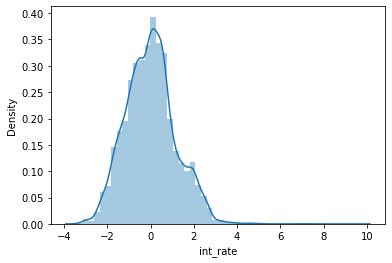

In [34]:
sns.distplot(y_pred - y_test, kde=True)

In [35]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.9105496596650865
Mean Squared Error: 1.335197278273473
Root Mean Squared Error: 1.1555073683337


#### Comparing Actual values against predicted by Linear Regression Model

In [36]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df


Actual  Predicted
19598    5.42   7.985700
2445     9.91  10.369575
31633   16.07  15.450583
35251   11.83  10.651964
24577   15.21  15.783905
...       ...        ...
4149    11.71  10.481755
912      9.91  10.494679
22397    6.54   7.965934
14920    7.49   8.048978
28101   15.95  15.918233

[12791 rows x 2 columns]

#### Using DecisionTreeRegressor model

In [38]:
param_grid = {"criterion": ["mse", "mae"],
              "max_depth": [2, 6, 8],
              "max_leaf_nodes": [5, 20, 40] }

In [39]:
dtm = DecisionTreeRegressor()

pipeline = createPipeLine(GridSearchCV(dtm, param_grid))

# Train the model using the training sets
pipeline.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = pipeline.predict(X_test)


R2 Score: 
 0.9264065728534324


In [50]:
X_train.columns

Index(['loan_amnt', 'term', 'grade', 'home_ownership', 'annual_inc',
       'purpose'],
      dtype='object')

In [68]:
ordinal_columns = ['grade']
categorical_columns = ['home_ownership','purpose', 'term']
numerical_columns = ['loan_amnt', 'annual_inc']

In [74]:
len(pipeline['gridsearchcv'].best_estimator_.feature_importances_)

23

In [80]:

features = ['loan_amnt', 'annual_inc', 'grade','home_ownership_MORTGAGE', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT', 'purpose_car',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding',
       'term_36', 'term_60']

len(features)

23

In [86]:
df = {'featureName': features, 'importance': pipeline['gridsearchcv'].best_estimator_.feature_importances_}
df = pd.DataFrame(data=df)
df

featureName  importance
0                    loan_amnt    0.001964
1                   annual_inc    0.000038
2                        grade    0.993081
3      home_ownership_MORTGAGE    0.000149
4         home_ownership_OTHER    0.000108
5           home_ownership_OWN    0.000037
6          home_ownership_RENT    0.000000
7                  purpose_car    0.000030
8          purpose_credit_card    0.000037
9   purpose_debt_consolidation    0.000000
10         purpose_educational    0.000186
11    purpose_home_improvement    0.000000
12               purpose_house    0.000000
13      purpose_major_purchase    0.000000
14             purpose_medical    0.000000
15              purpose_moving    0.000000
16               purpose_other    0.000000
17    purpose_renewable_energy    0.000000
18      purpose_small_business    0.000000
19            purpose_vacation    0.000000
20             purpose_wedding    0.000000
21                     term_36    0.002839
22                     term_60    0.001532

#### Evaluating the model

In [44]:
# The R2
print("R2 Score: \n", r2_score(y_test, y_pred))


R2 Score: 
 0.9264065728534324


#### Histogram of residuals 

/Users/karenpedraza/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='int_rate', ylabel='Density'>

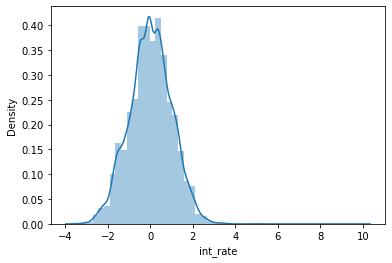

In [40]:
sns.distplot(y_pred - y_test, kde=True)

In [42]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [43]:
df

Actual  Predicted
19598    5.42   7.412582
2445     9.91  10.975309
31633   16.07  15.312271
35251   11.83  11.124129
24577   15.21  16.316497
...       ...        ...
4149    11.71  10.975309
912      9.91  10.975309
22397    6.54   7.412582
14920    7.49   7.412582
28101   15.95  15.887171

[12791 rows x 2 columns]

#### Getting the best parameters after running the GridSearchCV HyperParameter tuning

In [89]:
pipeline['gridsearchcv'].best_params_

{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 40}

## Final Model

According the previous results after fitting the data with `LinearRegression` and `DecisionTreeRegression`,
Although the first one got 90% of R2 and the second one just a slight difference with 92%. Comparing also the residuals 
DecisionTreeRegression has less margin of error approaching more to the 0.

Additionally, DecisionTreeRegression should be run with the following parameters 

```
{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 40}
```

DecisionTreeRegression is the final model